In [295]:
import lasagne
import numpy as np
import pickle
import skimage.transform
import scipy

import theano
import theano.tensor as T

from lasagne.utils import floatX

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread
from skimage import filters

In [26]:
from lasagne.layers import *
import sys
sys.path.append("../../modules/")
import helper as hp

In [144]:
def build_model(size=28):
    net = {}
    net['input'] = InputLayer((1, 1, size, size))
    net['conv1_1'] = Conv2DLayer(net['input'], num_filters=32, filter_size=(3,3))
    net['pool1'] = Pool2DLayer(net['conv1_1'], pool_size=(2,2), mode='average_exc_pad')
    net['conv1_2'] = Conv2DLayer(net['pool1'], num_filters=64, filter_size=(3,3))
    net['pool2'] = Pool2DLayer(net['conv1_2'], pool_size=(2,2), mode='average_exc_pad')
    net['conv1_3'] = Conv2DLayer(net['pool2'], num_filters=128, filter_size=(3,3))
    print "number of params: %i" % count_params(net["conv1_3"])
    for layer in get_all_layers(net["conv1_3"]):
        print layer, layer.output_shape
    return net

In [243]:
def build_model_2(size=128):
    net = {}
    net['input'] = InputLayer((1, 1, size, size))
    net['conv1_1'] = Conv2DLayer(net['input'], num_filters=32, filter_size=(3,3))
    net['pool1'] = Pool2DLayer(net['conv1_1'], pool_size=(2,2), mode='average_exc_pad')
    net['conv1_2'] = Conv2DLayer(net['pool1'], num_filters=64, filter_size=(3,3))
    net['pool2'] = Pool2DLayer(net['conv1_2'], pool_size=(2,2), mode='average_exc_pad')
    net['conv1_3'] = Conv2DLayer(net['pool2'], num_filters=128, filter_size=(3,3))
    net['pool3'] = Pool2DLayer(net['conv1_3'], pool_size=(2,2), mode='average_exc_pad')
    net['conv1_4'] = Conv2DLayer(net['pool3'], num_filters=256, filter_size=(3,3))    
    print "number of params: %i" % count_params(net["conv1_4"])
    for layer in get_all_layers(net["conv1_3"]):
        print layer, layer.output_shape
    return net

In [11]:
train_set, valid_set, test_set = hp.load_mnist("../../data/mnist.pkl.gz")
Xt, yt = train_set

In [13]:
Xt9 = Xt[ yt == 9, ]

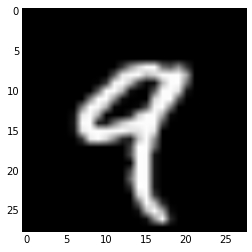

In [15]:
plt.imshow(Xt9[0:1][0][0], cmap="gray")

In [215]:
rock = imread("rocks2.jpg")
rock = rock.reshape( (1, 1, 64, 64) ).astype("float32")

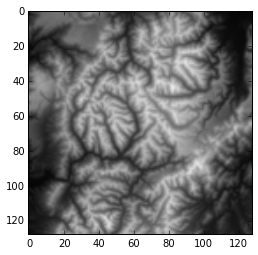

In [310]:
heightmap = imread("heightmap1.jpg") / 255.0
heightmap = heightmap.reshape( (1, 1, 128, 128) ).astype("float32")
plt.imshow(heightmap[0][0], cmap="gray", vmin=0, vmax=1)

In [249]:
def gram_matrix(x):
    x = x.flatten(ndim=3)
    g = T.tensordot(x, x, axes=([2], [2]))
    return g

def style_loss(A, X, layer):
    a = A[layer]
    x = X[layer]
    
    A = gram_matrix(a)
    G = gram_matrix(x)
    
    N = a.shape[1]
    M = a.shape[2] * a.shape[3]
    
    loss = 1./(4 * N**2 * M**2) * ((G - A)**2).sum()
    return loss

def total_variation_loss(x):
    return (((x[:,:,:-1,:-1] - x[:,:,1:,:-1])**2 + (x[:,:,:-1,:-1] - x[:,:,:-1,1:])**2)**1.25).sum()

In [251]:
net = build_model_2(size=128)

number of params: 387840
<lasagne.layers.input.InputLayer object at 0x12fdffa10> (1, 1, 128, 128)
<lasagne.layers.conv.Conv2DLayer object at 0x1220fae90> (1, 32, 126, 126)
<lasagne.layers.pool.Pool2DLayer object at 0x118826e10> (1, 32, 63, 63)
<lasagne.layers.conv.Conv2DLayer object at 0x1220fa590> (1, 64, 61, 61)
<lasagne.layers.pool.Pool2DLayer object at 0x1220fa650> (1, 64, 30, 30)
<lasagne.layers.conv.Conv2DLayer object at 0x12f0accd0> (1, 128, 28, 28)


In [252]:
layers = ['conv1_1', 'conv1_2', 'conv1_3']
layers = {k: net[k] for k in layers}

In [313]:
#photo = Xt9[0:1]
#photo = rock
photo = heightmap
print photo.dtype

float32


In [254]:
input_im_theano = T.tensor4()
outputs = lasagne.layers.get_output(layers.values(), input_im_theano)

art_features = {k: theano.shared(output.eval({input_im_theano: photo}))
                for k, output in zip(layers.keys(), outputs)}

In [255]:
art_features

{'conv1_1': <TensorType(float64, 4D)>,
 'conv1_2': <TensorType(float64, 4D)>,
 'conv1_3': <TensorType(float64, 4D)>}

In [256]:
generated_image = theano.shared(floatX(np.random.uniform(0, 1, photo.shape)))
gen_features = lasagne.layers.get_output(layers.values(), generated_image)
gen_features = {k: v for k, v in zip(layers.keys(), gen_features)}
gen_features

{'conv1_1': Elemwise{mul,no_inplace}.0,
 'conv1_2': Elemwise{mul,no_inplace}.0,
 'conv1_3': Elemwise{mul,no_inplace}.0}

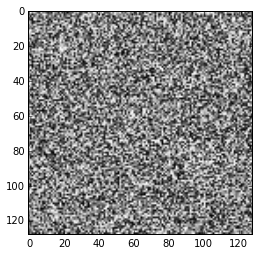

In [257]:
plt.imshow( generated_image.get_value()[0][0], cmap="gray", vmin=0, vmax=1 )

In [362]:
# Define loss function
losses = []

# style loss
losses.append(1e7*style_loss(art_features, gen_features, 'conv1_1'))
losses.append(1e7*style_loss(art_features, gen_features, 'conv1_2'))
losses.append(1e7*style_loss(art_features, gen_features, 'conv1_3'))

# total variation penalty 0.1e-7
losses.append(0.001 * total_variation_loss(generated_image))

total_loss = sum(losses)

In [363]:
grad = T.grad(total_loss, generated_image)

In [364]:
# Theano functions to evaluate loss and gradient
f_loss = theano.function([], total_loss)
f_grad = theano.function([], grad)

# Helper functions to interface with scipy.optimize
def eval_loss(x0):
    x0 = floatX(x0.reshape(photo.shape))
    generated_image.set_value(x0)
    return f_loss().astype('float64')

def eval_grad(x0):
    x0 = floatX(x0.reshape(photo.shape))
    generated_image.set_value(x0)
    return np.array(f_grad()).flatten().astype('float64')

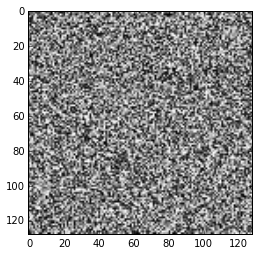

In [365]:
# Initialize with a noise image
generated_image.set_value(floatX(np.random.uniform(0, 1, photo.shape)*100+photo))
#generated_image.set_value( floatX( 
#        filters.gaussian_filter(photo[0][0], 5).reshape( photo.shape )
#) )
plt.imshow(generated_image.get_value()[0][0], cmap="gray")

In [366]:
x0 = generated_image.get_value().astype('float64')
xs = []
xs.append(x0)

# Optimize, saving the result periodically
for i in range(100):
    scipy.optimize.fmin_l_bfgs_b(eval_loss, x0.flatten(), fprime=eval_grad, maxfun=40)
    x0 = generated_image.get_value().astype('float64')
    xs.append(x0)

KeyboardInterrupt: 

77


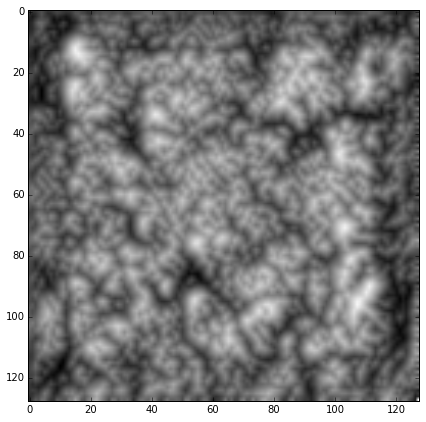

In [389]:
print len(xs)
plt.figure(figsize=(7,7))
plt.imshow(xs[-1][0][0], cmap='gray')

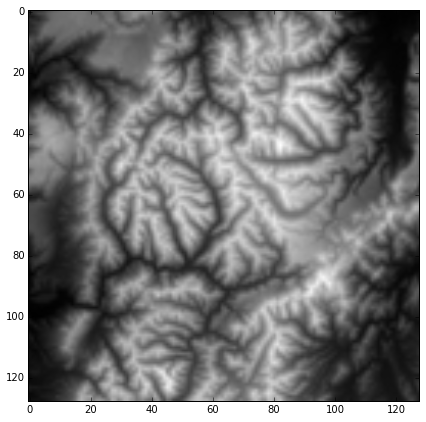

In [377]:
# original photo
plt.figure(figsize=(7,7))
plt.imshow(photo[0][0], cmap='gray')

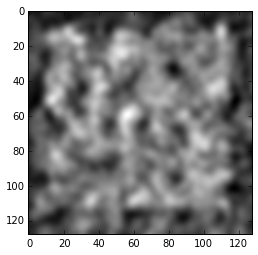

In [345]:
plt.imshow( filters.gaussian_filter(xs[-1][0][0], 2), cmap="gray")

----

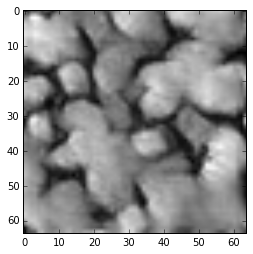

In [227]:
plt.imshow(xs[-1][0][0], cmap='gray')

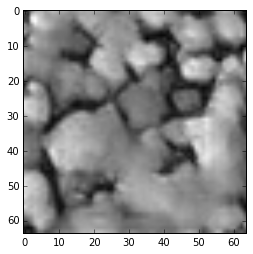

In [230]:
plt.imshow(xs[-1][0][0], cmap='gray')

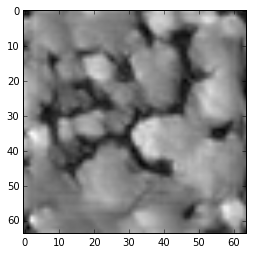

In [242]:
plt.imshow(xs[-1][0][0], cmap='gray')